## Data Inspection

In [1]:
%load_ext autoreload
%autoreload 2
from Libs.load_data import DataLoader
from Libs import flares_plot as fplt
from Libs.threshold import get_labels_physic, get_labels_KDE, get_labels_quantile, get_labels_quantile_on_run

In [2]:
# initialize data loader
data_loader = DataLoader()
# get the grid
grid = data_loader.get_grid()
# get params dictionary
params = data_loader.get_params()

params

{'run': 30,
 'sigma': [0.3, 0.4, 0.5, 0.6],
 'theta': [0.01, 0.1, 0.5, 3],
 'mu': [0.8, 0.9, 1, 1.1],
 'delta': [0.01, 0.05, 0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7],
 'N': 1000}

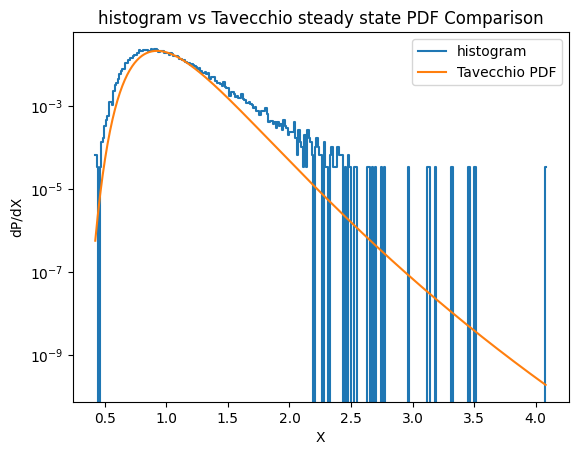

In [3]:
# if the light curve values are high for a certain combination of parameter the following plot could not work
# in that case try by increasing the dstep (default value 0.01)
run, mu, sigma, theta, delta = 0, 1, 0.5, 3, 0.2
title = 'histogram vs Tavecchio steady state PDF Comparison'
fplt.plot_grid_PDF(grid, params, nbins=300, run=run, sigma=sigma, theta=theta, mu=mu, delta=delta, 
                   on_run=False, dstep=1e-2, title=title)

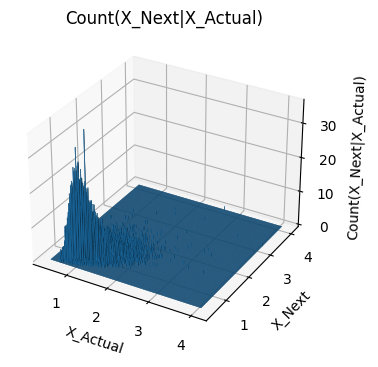

In [4]:
normalize=False
if normalize:
    title = 'P(X_Next|X_Actual)'
else:
    title = 'Count(X_Next|X_Actual)'
fplt.histogram_next_given_actual(grid, params, nbins=300, run=run, sigma=sigma, theta=theta, mu=mu, delta=delta, 
                                 on_run=False, normalize=normalize, title=title)

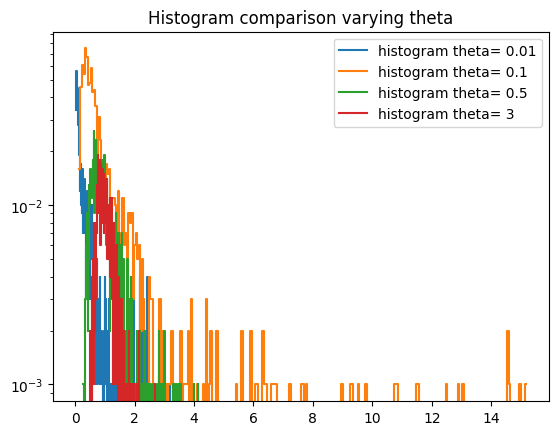

In [5]:
title = 'Histogram comparison varying theta'
fplt.plot_histograms(grid, params, nbins=300, sigma=sigma, mu=mu, delta=delta, variation='theta', on_run=True, title=title);

In [6]:
# get labels following physics method
physic_labels = get_labels_physic(grid, params, alpha=2)
# the first time this takes a lot time to generate labels, ~ 16' and 30''
kde_labels = get_labels_KDE(grid, params)
# get labels taking as a treshold a quantile of the values assumed by the light curves on different runs
quantile_labels = get_labels_quantile(grid, params, percentile = 0.7)
# get labels taking as a treshold a quantile of the values assumed by each light curve separately
# labels = get_labels_quantile_on_run(grid, params, percentile = 0.8)

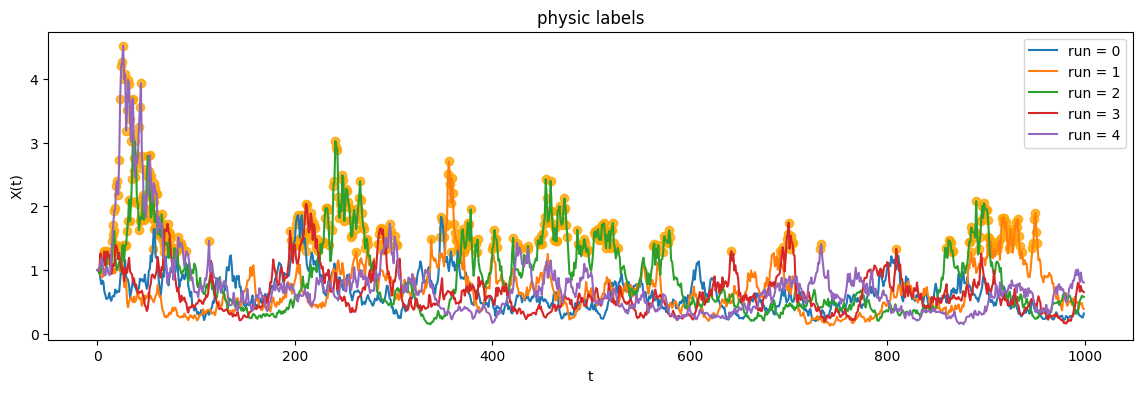

In [7]:
run, mu, sigma, theta, delta = 4, 0.8, 0.3, 0.1, 0.2
# focuses on specific runs
#fplt.plot_grid_datapoints(grid, params, run=run, mu=mu, sigma=sigma, theta=theta, delta=delta, labels=labels)
# focuses on a set of runs
fplt.plot_grid_datapoints(grid, params, mu=mu, sigma=sigma, theta=theta, delta=delta,
                          num_run=5, variation='run', labels=physic_labels, title='physic labels')

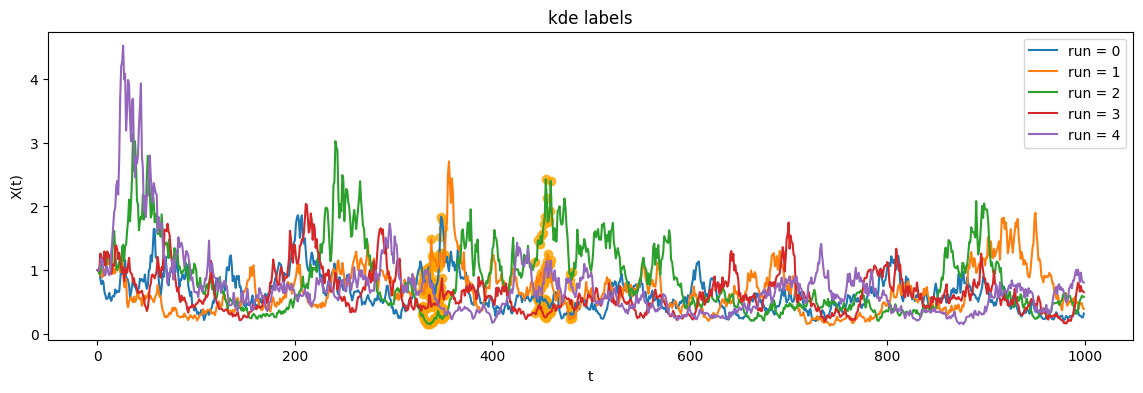

In [8]:
# focuses on specific runs
#fplt.plot_grid_datapoints(grid, params, run=run, mu=mu, sigma=sigma, theta=theta, delta=delta, labels=labels)
# focuses on a set of runs
fplt.plot_grid_datapoints(grid, params, mu=mu, sigma=sigma, theta=theta, delta=delta,
                          num_run=5, variation='run', labels=kde_labels, title='kde labels')

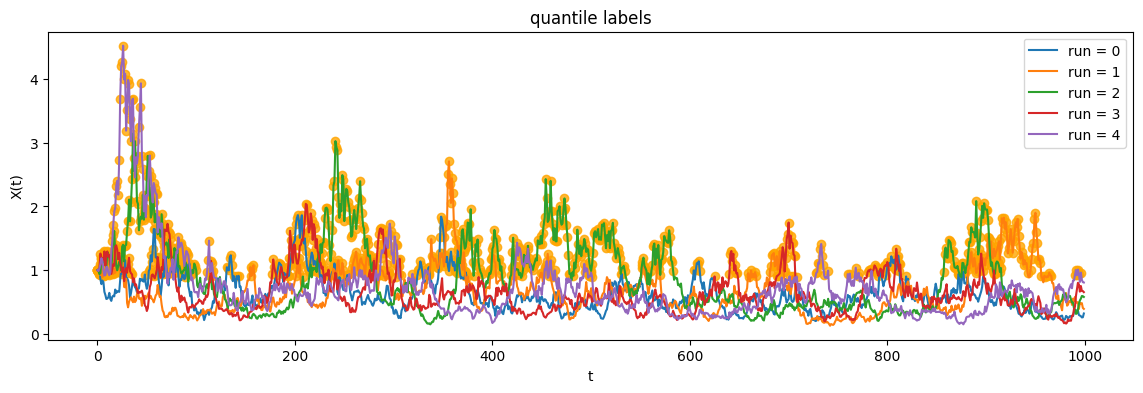

In [9]:
# focuses on specific runs
#fplt.plot_grid_datapoints(grid, params, run=run, mu=mu, sigma=sigma, theta=theta, delta=delta, labels=labels)
# focuses on a set of runs
fplt.plot_grid_datapoints(grid, params, mu=mu, sigma=sigma, theta=theta, delta=delta,
                          num_run=5, variation='run', labels=quantile_labels, title='quantile labels')

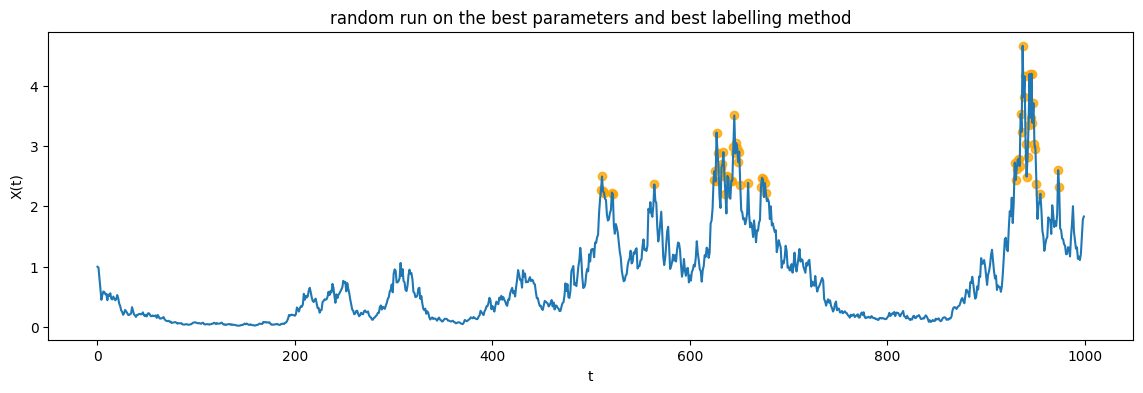

In [10]:
# # extract the standard values
run = 4
labels_best = physic_labels
# labels_best = kde_labels
# labels_best = quantile_labels
bindexes = data_loader.get_standard_indexes()
X_best = data_loader.get_standard_values(run=run)
best_labels = labels_best[run, bindexes[0], bindexes[1], bindexes[2], bindexes[3], :]

# # plot one single light curve
fplt.plot_serie(X_best, labels=best_labels, title='random run on the best parameters and best labelling method')

## Dataframe Building

In [11]:
import numpy as np
import pandas as pd

best_Xs = grid[:, bindexes[0], bindexes[1], bindexes[2], bindexes[3], :]
best_labels = labels_best[:, bindexes[0], bindexes[1], bindexes[2], bindexes[3], :]

window_size = 100
overlap_size = 50
label_treshold = 1
stride = window_size - overlap_size
num_windows = (best_Xs.shape[-1]-window_size)//stride + 1

windows = np.zeros((best_Xs.shape[0]*(num_windows-1),window_size))
windows_label = np.zeros((best_labels.shape[0]*(num_windows-1),window_size), dtype='bool')


for i in range(best_Xs.shape[0]):
    tmp_windows = np.array([best_Xs[i,j:j+window_size] for j in range(0,stride*num_windows,stride)])
    tmp_windows_labels = np.array([best_labels[i,j:j+window_size] for j in range(0,stride*num_windows,stride)])
    windows[i*(num_windows-1):(i+1)*(num_windows-1)] = tmp_windows[:-1,:]
    windows_label[i*(num_windows-1):(i+1)*(num_windows-1)] = tmp_windows_labels[1:,:]

windows_label = np.sum(windows_label, axis=-1)
windows_label[windows_label<label_treshold] = 0
windows_label[windows_label>=label_treshold] = 1

windows_df = pd.DataFrame(windows, columns=[f't_{i}' for i in range(windows.shape[-1])])
label_df = pd.DataFrame({'future_flare':windows_label})
labelled_windows_df = pd.concat([windows_df, label_df], axis=1)

labelled_windows_df



,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,t_9,...,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99,future_flare
0,1.000000,0.987600,1.015113,1.102188,1.172260,1.002175,1.102727,1.011016,0.972454,1.241815,...,0.546387,0.563971,0.500667,0.538432,0.752067,0.769070,0.768488,0.703136,0.733613,0
1,0.216969,0.158894,0.183269,0.232758,0.248276,0.198510,0.201367,0.173421,0.164503,0.143389,...,0.221842,0.173296,0.153174,0.166839,0.173306,0.174848,0.172071,0.198841,0.151521,0
2,0.549520,0.438043,0.434294,0.563741,0.498435,0.412277,0.416751,0.414491,0.466468,0.471037,...,0.055895,0.050392,0.044550,0.044228,0.044579,0.044516,0.039507,0.048195,0.057360,0
3,0.113256,0.120377,0.133855,0.108870,0.111364,0.086888,0.088882,0.125296,0.074523,0.056563,...,0.103260,0.101239,0.102645,0.082780,0.112830,0.107192,0.123765,0.110152,0.093077,0
4,0.061525,0.087007,0.077271,0.096791,0.078541,0.104705,0.095392,0.079260,0.097754,0.097792,...,0.050622,0.043392,0.040332,0.046251,0.033282,0.039079,0.041501,0.043818,0.045565,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,0.140494,0.142666,0.096294,0.069597,0.077192,0.077092,0.077394,0.077497,0.075563,0.087330,...,0.108609,0.098853,0.141090,0.122408,0.105622,0.112760,0.111503,0.125775,0.131990,1
536,0.049546,0.045011,0.043080,0.039333,0.038166,0.037105,0.041831,0.043947,0.043349,0.055392,...,2.014885,2.247014,2.283424,2.355769,2.438859,2.514316,3.113682,2.864890,3.196054,1
537,0.146840,0.234099,0.260062,0.255815,0.273638,0.258886,0.252493,0.257996,0.321399,0.272550,...,2.137624,2.205828,2.054609,2.069786,2.087259,2.323118,2.688682,2.639562,2.399463,1
538,3.010246,3.403312,4.764395,4.103238,3.859686,3.487066,3.159361,3.642124,2.935968,4.022541,...,3.633139,3.765466,3.509773,2.828506,3.536852,5.521716,5.349117,4.055315,4.047545,1
